In [1]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import numpy as np
import matplotlib.pyplot as plt
#from timm.models.layers import DropPath, to_2tuple, trunc_normal_

C:\Users\David\.conda\envs\CandidateNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
print(device)

cuda


In [4]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
#data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
#data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [5]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.EnsureChannelFirstD(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

In [6]:
slice_max = 423

In [7]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [8]:
print(labels.shape)

torch.Size([1, 1, 512, 512])


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

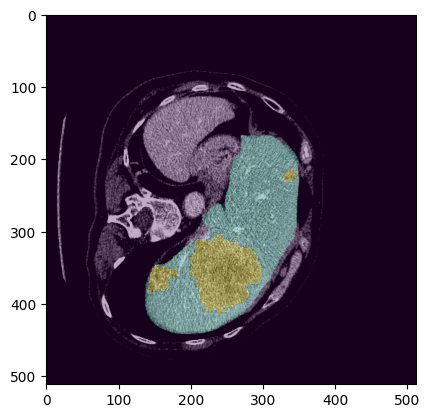

In [11]:
visualize_data(inputs, labels)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.block = nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.BatchNorm2d(out_dim),
                        nn.ReLU())
        
    def forward(self, x):
        return self.block(x)
        
    

In [13]:
class ConvTransBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.block = nn.Sequential(nn.ConvTranspose2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.BatchNorm2d(out_dim),
                        nn.ReLU())
        
    def forward(self, x):
        return self.block(x)

In [14]:
class RegularNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 3, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x):
        return self.net(x)
        
        

In [15]:
class UNetEncoder(nn.Module):
    def __init__(self, dim=32, levels=3):
        super().__init__()
        self.dim = dim
        self.blocks = nn.ModuleList()
        start_block = ConvBlock(1, dim, kernel_size=2, stride=2, padding=0)
        self.blocks.append(start_block)
        for i in range(1, levels):
            block = ConvBlock((2**(i - 1)) * dim, (2**i) * dim, kernel_size=3, stride=2, padding=1)
            self.blocks.append(block)
        
    def forward(self, x):
        out = []
        for block in self.blocks:
            x = block(x)
            out.append(x)
        return out
        

In [21]:
class UNetDecoder(nn.Module):
    def __init__(self, dim=32, levels=3):
        super().__init__()
        self.dim = dim
        self.levels = levels
        self.blocks = nn.ModuleList()
        for i in range(levels, 0, -1):
            block = ConvTransBlock((2 ** (i - 1)) * dim, int((2 ** (i - 2)) * dim), kernel_size=2, stride=2, padding=0)
            self.blocks.append(block)
        self.out = ConvBlock(dim // 2, 3)
        
    def forward(self, x):
        x_out = self.blocks[0](x[-1])
        for i in range(1, self.levels):
            x_out = self.blocks[i](x[-(i+1)] + x_out)
        out = self.out(x_out)
        return out

In [22]:
class UNet(nn.Module):
    def __init__(self, dim=32, levels=3):
        super().__init__()
        self.dim = dim
        self.levels = levels
        self.encoder = UNetEncoder(dim, levels)
        self.decoder = UNetDecoder(dim, levels)
        
    def forward(self, x):
        enc_out = self.encoder(x)
        dec_out = self.decoder(enc_out)
        return dec_out

In [23]:
def select_entropy_candidates(x, n=5000):
    B, C, H, W = x.shape
    sm = F.softmax(x, dim=1)
    entr = torch.sum(torch.special.entr(sm), dim=1)
    entr = entr.view(B, -1)
    candidates = torch.zeros(B, 1, H, W)
    candidates = candidates.view(B, -1)
    top_e, top_e_ind = torch.topk(entr, n, dim=1, largest=True)
    candidates[:,top_e_ind] = 1
    candidates = candidates.view(B, 1, H, W)
    
    return candidates

In [58]:
model2 = UNet(dim=64, levels=4)
model2.to(device)
print(model2)
print(count_parameters(model2))

UNet(
  (encoder): UNetEncoder(
    (blocks): ModuleList(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (3): ConvBlock(
        (block): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): Batc

Starting Training...
Epoch: 99, Dice score: 0.7097740173339844, loss: 1.2483901977539062, lr: [0.0009760113134728371]
Epoch: 199, Dice score: 0.8464622497558594, loss: 1.1969698667526245, lr: [0.0009054297904161855]
Epoch: 299, Dice score: 0.8952085375785828, loss: 1.160831093788147, lr: [0.0007951619746781464]
Epoch: 399, Dice score: 0.9202054738998413, loss: 1.13545560836792, lr: [0.0006560016483442069]
Epoch: 499, Dice score: 0.935444712638855, loss: 1.1174260377883911, lr: [0.0005015707937429391]
Epoch: 599, Dice score: 0.9457706809043884, loss: 1.1054905652999878, lr: [0.00034698617890574935]
Epoch: 699, Dice score: 0.9532256126403809, loss: 1.098172664642334, lr: [0.00020737962298724474]
Epoch: 799, Dice score: 0.9588563442230225, loss: 1.0943024158477783, lr: [9.641678837679975e-05]
Epoch: 899, Dice score: 0.9632564187049866, loss: 1.0928151607513428, lr: [2.495949044961403e-05]
Epoch: 999, Dice score: 0.966796338558197, loss: 1.0925899744033813, lr: [2.4673990708934305e-09]


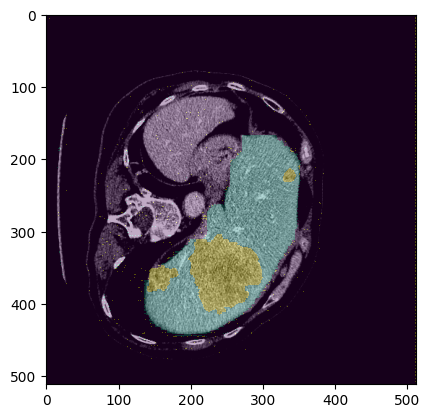

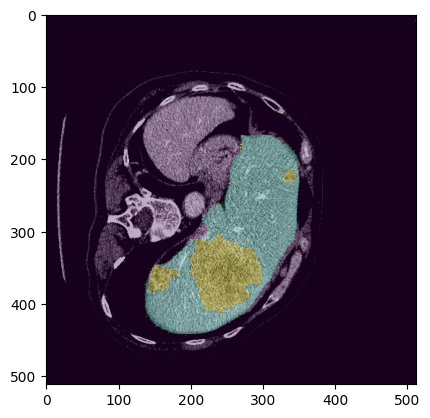

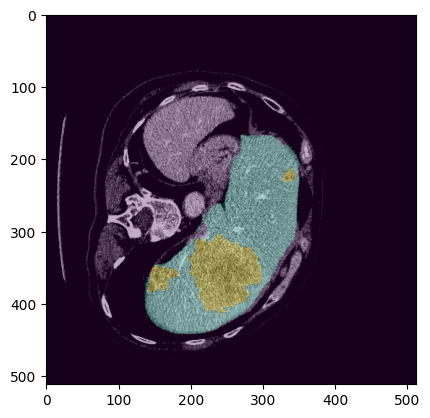

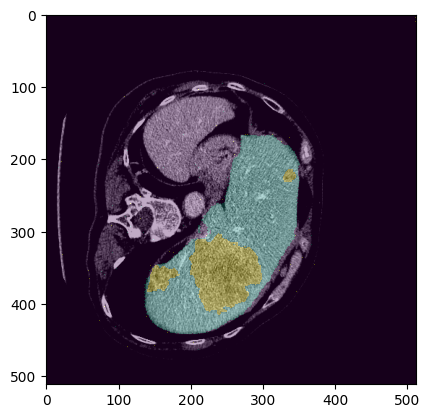

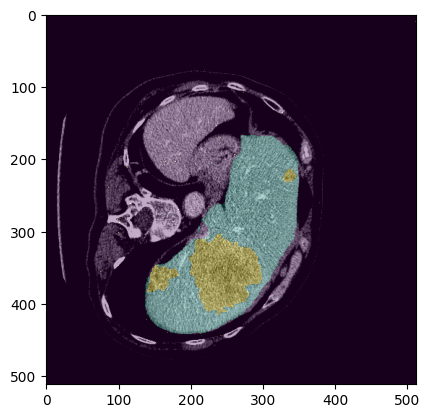

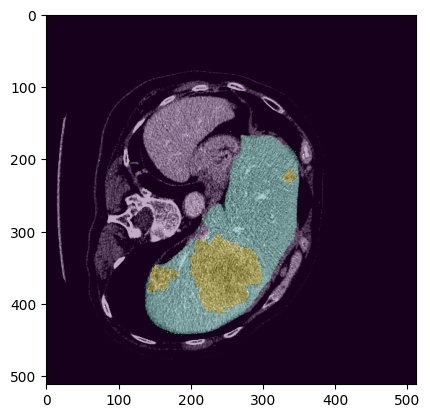

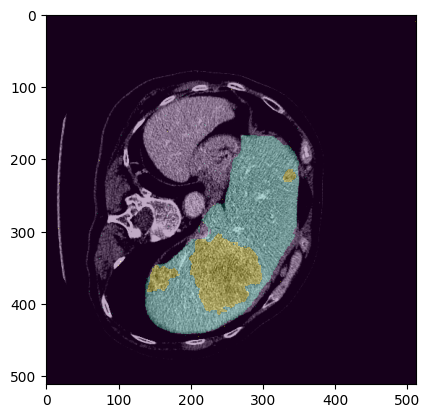

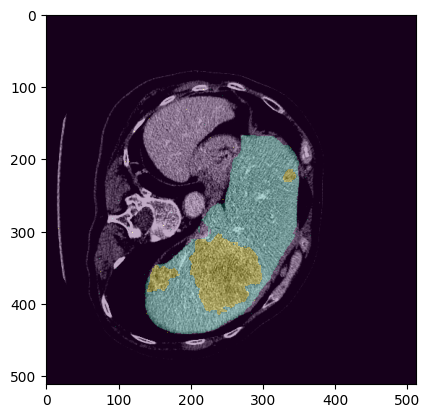

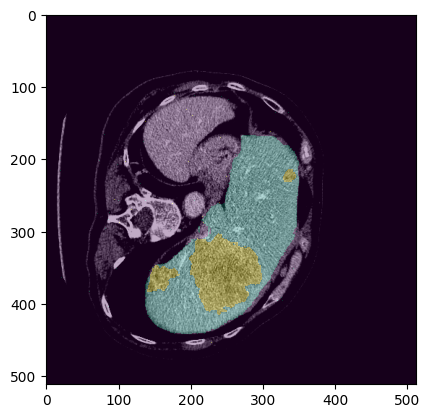

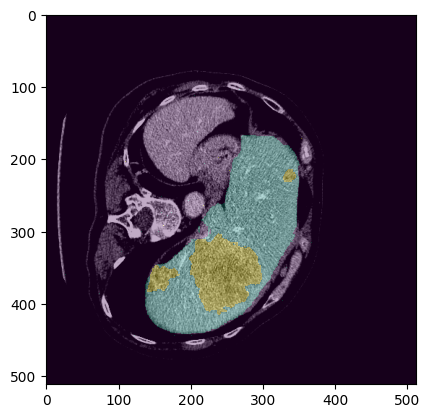

In [59]:
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-3)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

print("Starting Training...")
for e in range(epochs):
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    labels_convert = [post_label(labels[0])]
    output_convert = [post_pred(outputs[0])]
    dice_metric(y_pred=output_convert, y=labels_convert)
    dice_scores, dice_not_nans = dice_metric.aggregate()
    if ((e + 1) % print_every_n_epochs) == 0:
        print("Epoch: {}, Dice score: {}, loss: {}, lr: {}".format(e, dice_scores.item(), loss.item(), scheduler.get_last_lr()))
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
    scheduler.step()

In [ ]:
class CandidateNetwork(nn.Module):
    def __init__(self, dim=32, levels=5):
        super().__init__()
        self.dim = dim
        self.encoder = UNetEncoder(dim, levels)
        self.decoder = UNetDecoder(dim, levels)
        
        self.out_loss_pred = ConvBlock(dim * 2**(levels - 1), 1)
        
    def forward(self, x):
        enc_out = self.encoder(x)
        pred = self.decoder(enc_out)
        loss_pred = self.out_loss_pred(enc_out[-1])
        return pred, loss_pred 

In [ ]:
class CandidateNetwork2(nn.Module):
    def __init__(self, dim=32, levels=5, candidates=16, candidate_attention=True):
        super().__init__()
        self.dim = dim
        self.candidates = candidates
        self.candidate_attn = candidate_attention
        self.encoder = UNetEncoder(dim, levels)
        self.decoder = UNetDecoder(dim, levels)
        self.final_dim = dim * 2**(levels - 1)
        self.final_size = 512 // 2**(levels - 1)
        if self.candidate_attn:
            encoder_layer = torch.nn.TransformerEncoderLayer(self.final_dim, 8, dim_feedforward=self.final_dim, dropout=0.1, activation='gelu', batch_first=True, norm_first=True) 
            self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=1, enable_nested_tensor=False)
            self.position_bias = torch.nn.Embedding(self.final_size * self.final_size, self.final_dim)
        
        self.out_loss_pred = ConvBlock(dim * 2**(levels - 1), 1)
        
    def forward(self, x):
        enc_out = self.encoder(x)
        enc_final = enc_out[-1]     
        loss_pred = self.out_loss_pred(enc_final)
        
        if self.candidate_attn:
            lp = loss_pred.view(-1)
            top_indices = torch.topk(lp, k=self.candidates).indices
            enc_final_flat = enc_final.view(enc_final.shape[0], self.final_dim, -1)
            top_features = enc_final_flat[:,:,top_indices]
            top_features = top_features.permute(0, 2, 1)
            pos_bias = self.position_bias(top_indices.int().unsqueeze(0))
            top_features = top_features + pos_bias
            enc_features = self.transformer_encoder(top_features)
            enc_features = enc_features.permute(0, 2, 1)
            enc_final_flat = enc_final_flat.scatter(2, top_indices.view(1, 1, -1).expand(1, self.final_dim, -1), enc_features)
            enc_final = enc_final_flat.view(enc_final.shape[0], self.final_dim, enc_final.shape[2], enc_final.shape[3])
            enc_out[-1] = enc_final
        
        pred = self.decoder(enc_out)

        return pred, loss_pred 

In [ ]:
model = CandidateNetwork2(dim=16, levels=5, candidates=32, candidate_attention=True)
model.to(device)
print(count_parameters(model))
#print(model)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, total_iters=10)
criterion1 = monai.losses.FocalLoss(to_onehot_y=True, use_softmax=True, reduction='none')
criterion2 = monai.losses.DiceLoss(to_onehot_y=True, softmax=True, squared_pred=False, reduction='mean')
criterion3 = torch.nn.MSELoss(reduction='none')
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints
visual_sel_windows = None
candidates = 32


for e in range(epochs):
    outputs, loss_pred = model(inputs)
    loss1 = criterion1(outputs, labels)
    loss2 = criterion2(outputs, labels)
    window_size = loss1.shape[2] // loss_pred.shape[2]
    loss1_copy = loss1.clone().detach()
    loss1_windowed = loss1_copy.view(loss1.shape[0], loss1.shape[1], loss1.shape[2] // window_size, window_size, loss1.shape[3] // window_size, window_size)
    loss1_windowed = loss1_windowed.permute(0, 1, 2, 4, 3, 5).contiguous()
    loss1_windowed = loss1_windowed.reshape(loss1_windowed.shape[0], loss1_windowed.shape[1], loss1_windowed.shape[2], loss1_windowed.shape[3], -1)
    loss1_windowed = loss1_windowed.sum(dim=-1)
    loss1_windowed = loss1_windowed[:,1:].sum(dim=1, keepdim=True)
    #print(loss1_windowed.shape)
    
    #print(loss1_windowed.shape)
    loss3 = criterion3(loss_pred, loss1_windowed)
    
    lp = loss_pred.detach().view(-1)
    top_indices = torch.topk(lp, k=candidates).indices
    bottom_indices = torch.topk(lp, k=candidates, largest=False).indices
    top_bot_pred_loss = torch.zeros_like(lp)
    for k in range(len(top_indices)):
        top_bot_pred_loss[top_indices[k]] = 1
    for k in range(len(bottom_indices)):
        top_bot_pred_loss[bottom_indices[k]] = 2
    top_bot_pred_loss = top_bot_pred_loss.view(loss_pred.shape[2], loss_pred.shape[3])
    top_bot_pred_loss = top_bot_pred_loss.repeat_interleave(window_size, dim=0).repeat_interleave(window_size, dim=1)
    top_bot_pred_loss = top_bot_pred_loss.unsqueeze(0).unsqueeze(0)
    
    
    optimizer.zero_grad()
    loss1 = loss1.mean()
    loss3 = loss3.mean()
    #print(loss3)
    loss = loss1 + loss2 + 0.25*loss3
    loss.backward()
    optimizer.step()
    scheduler.step()

    labels_convert = [post_label(labels[0])]
    output_convert = [post_pred(outputs[0])]
    dice_metric(y_pred=output_convert, y=labels_convert)
    dice_scores, dice_not_nans = dice_metric.aggregate()
    if ((e + 1) % print_every_n_epochs) == 0:
        if not visual_sel_windows is None:
            init_pred = torch.argmax(init_outputs, dim=1)
            visualize_data(inputs, init_pred)
            visualize_data(inputs, visual_sel_windows)
            #visualize_data(inputs, sf_norm.detach())
            print("Epoch: {}, Dice score: {:.3f}, init ce loss: {:.3f}, cand ce loss: {:.3f}, meta loss: {:.3f}, tot loss: {:.3f}".format(e, dice_scores.item(), ce_loss_init.item(), ce_loss_cand.item(), meta_loss.item(), loss.item()))
        else:
            print("Epoch: {}, Dice score: {}, loss: {}".format(e, dice_scores.item(), loss.item()))
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
        visualize_data(inputs, top_bot_pred_loss)


In [ ]:
test = torch.randn(1, 1, 16, 16)
test = test.view(1,1,16*16)
toptwo = torch.topk(test, k=2, dim=2).indices
print(toptwo)
test2 = torch.zeros_like(test)
#test2[0, 0, toptwo[0,0,0]] = 1
#test2[0, 0, toptwo[0,0,1]] = 2
test2[0, 0, 0] = 1
test2[0, 0, 255] = 2
test2[0, 0, 134] = 3
test2 = test2.view(16,16)

expanded_tensor = test2.repeat_interleave(32, dim=0).repeat_interleave(32, dim=1)
print(expanded_tensor.shape)
expanded_tensor = expanded_tensor.unsqueeze(0).unsqueeze(0)


visualize_data(inputs, expanded_tensor)

In [ ]:
full_size = 512
window_size = 32

# Calculate the number of windows along one dimension
num_windows = full_size // window_size

# Create a tensor of window values
window_values = torch.arange(num_windows * num_windows).reshape(num_windows, num_windows)

# Repeat each window value within a 32x32 window
windowed_tensor = window_values.repeat_interleave(window_size, dim=0).repeat_interleave(window_size, dim=1)


print(windowed_tensor[0])
visualize_data(inputs, windowed_tensor.unsqueeze(0).unsqueeze(0))